<a href="https://colab.research.google.com/github/nguyenanhtienabcd/M09_PROJECT_MUSIC_GENERATION/blob/feature%2Fmusic-generation/m09w03_project_music_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tạo ra âm thanh từ các dữ liệu được training

## Thu thập dữ liệu từ trang web

In [1]:
%%bash
# Ubuntu hiện không phân phối Chromium ngoài snap, vì vậy ta thêm repository Debian Buster
# Tham khảo: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Thêm repository Debian Buster
cat << "EOF" | sudo tee /etc/apt/sources.list.d/debian.list
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Thêm khóa công khai cần thiết từ keyserver của Ubuntu
sudo apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
sudo apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
sudo apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

# Xuất các khóa và lưu vào keyrings tương ứng
sudo apt-key export 77E11517 | sudo gpg --dearmor -o /usr/share/keyrings/debian-buster.gpg
sudo apt-key export 22F3D138 | sudo gpg --dearmor -o /usr/share/keyrings/debian-buster-updates.gpg
sudo apt-key export E562B32A | sudo gpg --dearmor -o /usr/share/keyrings/debian-security-buster.gpg

# Ưu tiên repository Debian cho các gói liên quan đến Chromium
cat << "EOF" | sudo tee /etc/apt/preferences.d/chromium.pref
Package: *
Pin: release a=eoan
Pin-Priority: 500

Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300

Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Cập nhật danh sách gói và cài đặt Chromium cùng Chromium Driver
sudo apt-get update
sudo apt-get install -y chromium chromium-driver

# Cài đặt thư viện Selenium cho Python
pip install selenium

deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
Executing: /tmp/apt-key-gpghome.WNvNeRU4sj/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
Executing: /tmp/apt-key-gpghome.0TZKLGPftG/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
Executing: /tmp/apt-key-gpghome.9kAv3bSJyT/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
Package: *
Pin: release a=eoan
Pin-Priority: 500

Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300

Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
Hit:1 http://deb.debian.org/debian buster InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:3 

gpg: key DCC9EFBF77E11517: "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
gpg: key DC30D7C23CBBABEE: "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
gpg: key 4DFAB270CAA96DFA: "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
gpg: cannot open '/dev/tty': No such device or address
gpg: [stdout]: write error: Broken pipe
gpg: filter_flush failed on close: Broken pipe
gpg: cannot open '/dev/tty': No such device or address
gpg: [stdout]: write error: Broken pipe
gpg: filter_flush failed on close: Broken pipe
gpg: cannot open '/dev/tty': No such device or address
gpg: [stdout]: write error: Broken pipe
gpg: filter_flush failed on close: Broken pipe
W: Skipping acquire of configured file '

In [2]:
import os
import requests
import time
import json

from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [3]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait

# ⏱️ Thời gian chờ mặc định (đơn vị: giây)
WEBDRIVER_DELAY_TIME_INT = 10  # Dùng cho WebDriverWait
TIMEOUT_INT = 10               # Dùng cho implicitly_wait (chờ tìm phần tử)

# 🚗 Khởi tạo Service với đường dẫn đến ChromeDriver
# Chú ý: Bỏ khoảng trắng thừa trong đường dẫn
service = Service(executable_path=r"/usr/bin/chromedriver")

# ⚙️ Khởi tạo tùy chọn cho Chrome
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--headless")                     # Chạy ở chế độ không hiển thị cửa sổ trình duyệt
chrome_options.add_argument("--no-sandbox")                   # Tắt sandbox (giúp tránh lỗi khi chạy trên hệ thống ảo hóa)
chrome_options.add_argument("--disable-dev-shm-usage")        # Tránh dùng bộ nhớ chia sẻ (giúp chạy ổn định hơn trên Colab)
chrome_options.add_argument("window-size=1920x1080")          # Đặt kích thước cửa sổ trình duyệt
chrome_options.headless = True                                # Một cách khác để bật headless (không bắt buộc nếu đã dùng dòng 1)

# 🧭 Khởi tạo trình điều khiển Chrome với các tùy chọn đã cấu hình
driver = webdriver.Chrome(service=service, options=chrome_options)

# ⏳ Đặt thời gian chờ ngầm cho tất cả thao tác tìm phần tử
driver.implicitly_wait(TIMEOUT_INT)

# 🕐 Tạo đối tượng WebDriverWait để chờ đợi phần tử xuất hiện theo điều kiện cụ thể
wait = WebDriverWait(driver, WEBDRIVER_DELAY_TIME_INT)



vào trang web https://freemusicarchive.org/genre/piano/ sau đấy vào từng dòng nhạc, click chuột phải và vào "inspect" để xem thêm thông tin về trang

In [4]:
def extract_audio_links_from_menu(menu_url, driver):
    # Truy cập vào trang danh sách nhạc
    driver.get(menu_url)

    # Chờ cho đến khi container chứa danh sách nhạc xuất hiện trên trang
    container = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located(
            (By.CSS_SELECTOR, "div.w-full.flex.flex-col.gap-3.pt-3")
        )
    )

    # Lấy tất cả các item nhạc trong container
    play_items = container.find_elements(By.CSS_SELECTOR, "div.play-item")

    # Danh sách chứa các link bài hát
    links = []

    # Lặp qua từng item để lấy link bài hát
    for item in play_items:
        try:
            # Tìm thẻ <a> chứa đường dẫn bài hát
            a_tag = item.find_element(By.CSS_SELECTOR, "span.ptxt-track a")
            link = a_tag.get_attribute("href")

            # Thêm link vào danh sách
            links.append(link)

        except Exception:
            # Nếu xảy ra lỗi (ví dụ không tìm thấy thẻ a), bỏ qua và tiếp tục
            continue

    return links


In [5]:
#https://freemusicarchive.org/genre/piano/?page=1

In [ ]:
menu_url = "https://freemusicarchive.org/genre/piano/?page=1"
links = extract_audio_links_from_menu(menu_url, driver)
links

In [ ]:
import requests

def download_audio_file(file_url, filepath):
    """
    Hàm dùng để tải file audio từ một đường dẫn URL về máy và lưu với tên chỉ định.

    Tham số:
    - file_url: URL của file âm thanh cần tải
    - filepath: đường dẫn + tên file lưu về máy (ví dụ: 'downloads/song.mp3')
    """

    # Gửi yêu cầu GET đến URL, cho phép stream dữ liệu về
    response = requests.get(file_url, stream=True)

    # Nếu yêu cầu thành công (HTTP 200 OK)
    if response.status_code == 200:
        # Mở file để ghi nhị phân ('wb' = write binary)
        with open(filepath, "wb") as f:
            # Đọc và ghi từng phần nhỏ (chunk) của dữ liệu (tránh lỗi khi file lớn)
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f" Đã tải xong: {filepath}")

    else:
        # Nếu lỗi, in ra thông báo lỗi kèm mã trạng thái HTTP
        print(f" Error downloading file from {file_url}; status: {response.status_code}")


In [ ]:
# xây dựng các hàm trích xuất nội dung trong file âm nhạc
def extract_track_info(driver):
    """
    Hàm này dùng để trích xuất thông tin bài hát (bao gồm URL tải nhạc)
    từ một phần tử chứa thuộc tính 'data-track-info' dưới dạng JSON.
    """

    # Chờ tối đa 15 giây để phần tử chứa thuộc tính 'data-track-info' xuất hiện trong trang
    audio_div = WebDriverWait(driver, 15).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, "div[data-track-info]"))
    )

    # Lấy nội dung từ thuộc tính 'data-track-info' (chuỗi JSON)
    data_json = audio_div.get_attribute("data-track-info")

    # Chuyển từ chuỗi JSON sang dict Python và trả về
    return json.loads(data_json)

In [ ]:
def extract_genres(driver):
    """
    Trích xuất danh sách thể loại nhạc (genres) từ trang chi tiết bài hát.

    Trả về: danh sách các chuỗi genre name.
    """
    try:
        # Tìm phần tử chứa danh sách genres (span với các class như trong ảnh)
        genre_elem = driver.find_element(
            By.CSS_SELECTOR, "span.md\\:col-span-6.flex.flex-wrap.gap-3"
        )

        # Tìm tất cả thẻ <a> bên trong (mỗi thẻ <a> chứa một thể loại)
        return [a.text.strip() for a in genre_elem.find_elements(By.TAG_NAME, "a") if a.text.strip()]

    except Exception:
        # Nếu không tìm thấy hoặc có lỗi, trả về danh sách rỗng
        return []

In [ ]:
def extract_duration(driver):
    try:
        duration_elem = driver.find_element(
            By.CSS_SELECTOR,
            "span.w-12.ml-auto.md\\:ml-0.col-span-2.inline-flex.justify-end.items-center",
        )
        return duration_elem.text.strip()
    except Exception:
        return None

# Ví dụ cách sử dụng:
# Giả sử bạn đã có driver đang ở trên trang chi tiết của bài hát
# duration = extract_duration(driver)
# print(duration)


In [ ]:
from selenium.webdriver.common.by import By

def extract_extra_info(driver):
    """
    Hàm trích xuất các thông tin phụ của bài nhạc như:
    - Có phải là nhạc không lời (Instrumental)?
    - Có phải là nhạc được tạo bởi AI không (AI generated)?

    Trả về:
    - instrumental: "Yes"/"No"
    - ai_generated: "Yes"/"No"
    """
    instrumental = "No"
    ai_generated = "No"

    try:
        # Tìm phần tử bao ngoài chứa thông tin phụ
        info_container = driver.find_element(
            By.CSS_SELECTOR,
            "div.px-8.py-2.bg-gray-light.flex.flex-col.divide-y.divide-gray"
        )

        # Tìm các khối thông tin riêng biệt bên trong container
        info_divs = info_container.find_elements(
            By.CSS_SELECTOR,
            "div.grid.grid-cols-1.md\\:grid-cons-8.py-6"
        )

        # Lặp qua từng dòng thông tin
        for div in info_divs:
            #  Tên nhãn (label): "Instrumental", "AI generated?", ...
            label = div.find_element(
                By.CSS_SELECTOR,
                "span.font-\\[500\\].md\\:col-span-2"
            ).text.strip()

            #  Giá trị: "Yes", "No", ...
            value = div.find_element(
                By.CSS_SELECTOR,
                "span.md\\:col-span-6"
            ).text.strip()

            #  Kiểm tra nếu là nhãn "Instrumental"
            if "Instrumental" in label:
                instrumental = value

            #  Kiểm tra nếu là nhãn "AI generated?"
            if "AI generated?" in label:
                ai_generated = value

    except Exception:
        # Tránh lỗi khi không tìm thấy hoặc selector sai
        pass

    return instrumental, ai_generated


URL bài hát \\
   ↓ \\
Selenium driver truy cập \\
   ↓ \\
🧠 extract_track_info() \\
   → lấy JSON từ data-track-info \\
   → lấy fileUrl, title, artist \\

🎼 extract_genres() \\
   → lấy các thể loại nhạc \\

🎛 extract_extra_info() \\
   → có phải AI tạo ra không? có phải instrumental không? \\

⏱ extract_duration() \\
   → lấy thời lượng bài hát \\

⬇️ download_audio_file() \\
   → tải file MP3 \\

📝 Lưu file JSON metadata \\


In [ ]:

def process_audio_page(audio_url, driver, index):
    # Truy cập trang chi tiết bài hát
    driver.get(audio_url)

    # Trích xuất thông tin từ data-track-info
    track_info = extract_track_info(driver)
    file_url = track_info.get("fileUrl", "")
    audio_name = track_info.get("title", "").strip()
    author = track_info.get("artistName", "").strip()

    # Trích xuất thể loại, thời lượng, các thông tin phụ khác
    genres = extract_genres(driver)
    duration = extract_duration(driver)
    instrumental, ai_generated = extract_extra_info(driver)

    # Tạo metadata dưới dạng dictionary
    metadata = {
        "audioName": audio_name,
        "author": author,
        "genres": genres,
        "instrumental": instrumental,
        "ai_generated": ai_generated,
        "duration": duration,
        "audio_url": audio_url
    }

    # Tạo tên file cho audio và metadata
    audio_filename = f"audio_{index:04d}.mp3"
    meta_filename = f"audio_{index:04d}.json"

    # Đường dẫn lưu file
    audio_filepath = os.path.join("crawled_data", "audio", audio_filename)
    meta_filepath = os.path.join("crawled_data", meta_filename)

    # Tải file mp3 về
    download_audio_file(file_url, audio_filepath)

    # Lưu metadata dạng JSON
    with open(meta_filepath, "w", encoding="utf-8") as f:
        json.dump(metadata, f, ensure_ascii=False, indent=4)

    return metadata


In [ ]:
from tqdm import tqdm  # để hiện progress bar

def loop_over_menu_pages(base_url, total_pages, driver):
    """
    Hàm này duyệt qua từng trang của danh sách nhạc (menu),
    và thu thập tất cả các link bài hát từ từng trang.

    Tham số:
    - base_url: đường dẫn cơ sở (ví dụ: "https://freemusicarchive.org/genre/Piano")
    - total_pages: tổng số trang muốn duyệt qua
    - driver: đối tượng Selenium WebDriver đang hoạt động

    Trả về:
    - all_links: danh sách tất cả link bài hát trích được
    """
    all_links = []

    # Duyệt qua từng trang từ 1 đến total_pages
    for page in tqdm(range(1, total_pages + 1), desc="Extracting Links", unit="page"):
        page_url = f"{base_url}?page={page}"
        try:
            # Gọi hàm đã định nghĩa trước đó để lấy link từ trang hiện tại
            links = extract_audio_links_from_menu(page_url, driver)

            # Nối danh sách links mới vào danh sách tổng
            all_links.extend(links)

        except Exception as e:
            print(f"Error on page {page}: {e}")

    return all_links


Thực thi quá trình thu thập dữ liệu

In [ ]:
# Tạo thư mục lưu dữ liệu nếu chưa tồn tại
os.makedirs("crawled_data", exist_ok=True)
os.makedirs(os.path.join("crawled_data", "audio"), exist_ok=True)

# 🔗 Cấu hình URL danh sách nhạc (ví dụ: thể loại Piano)
base_url = "https://freemusicarchive.org/genre/piano/"
total_pages = 10  # số trang bạn muốn quét
sample_idx = 1

# 🔄 Duyệt qua các trang và lấy tất cả link bài hát
audio_links = loop_over_menu_pages(base_url, total_pages, driver)
print(f"Total audio links extracted: {len(audio_links)}")

# 🎧 Tải từng bài hát và lưu metadata
for audio_url in tqdm(audio_links, desc="Downloading Audio and Metadata", unit="audio"):
    try:
        process_audio_page(audio_url, driver, sample_idx)
        sample_idx += 1

    except Exception as e:
        print(f" Error at: {audio_url} - {e}")
        continue

    time.sleep(0.5)  #  Nghỉ 0.5 giây giữa mỗi bài để tránh bị chặn

# ✅ Đóng trình duyệt
driver.quit()


## Xây dựng chương trình training dữ liệu

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import json
import timm

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from IPython.display import Audio
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os
import requests
import time
import json

In [5]:
!gdown 1u2WzsWUlyZbbPDfXAWXuLRMTwFkT21wa
!unzip -q crawled_piano_audio_40_pages.zip -d piano_audio_files_40_pages
import os
os.remove("crawled_piano_audio_40_pages.zip")


Downloading...
From (original): https://drive.google.com/uc?id=1u2WzsWUlyZbbPDfXAWXuLRMTwFkT21wa
From (redirected): https://drive.google.com/uc?id=1u2WzsWUlyZbbPDfXAWXuLRMTwFkT21wa&confirm=t&uuid=ce8ba682-f1a8-464b-b30a-d6406693c55d
To: /content/crawled_piano_audio_40_pages.zip
100% 4.35G/4.35G [00:49<00:00, 88.4MB/s]


#### Xây dựng các hàm cơ bản

In [6]:
def load_and_get_genres(json_path):
  """Loads a JSON file and returns the 'genres' list from it.

  Args:
    json_path: The path to the JSON file.

  Returns:
    A list of genres, or an empty list if the 'genres' key is not found.
  """
  with open(json_path, "r") as f:
    data = json.load(f)
  return data.get("genres", [])


In [7]:
import librosa

def load_and_resample_audio(file_path, target_sr=22050):
  """
  Hàm này tải một file âm thanh và resample nó về tần số lấy mẫu mục tiêu.

  Args:
    file_path: Đường dẫn tới file âm thanh.
    target_sr: Tần số lấy mẫu mục tiêu (mặc định là 22050 Hz).

  Returns:
    Một tuple chứa:
      - audio: Mảng NumPy chứa dữ liệu âm thanh.
      - target_sr: Tần số lấy mẫu của dữ liệu âm thanh.
  """
  audio, sr = librosa.load(file_path, sr=None)
  if sr != target_sr: # Kiểm tra xem tần số mẫu của file có khớp với target_sr không
    audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr) # chuyển file sang target_sr mong muốn

  return audio, target_sr


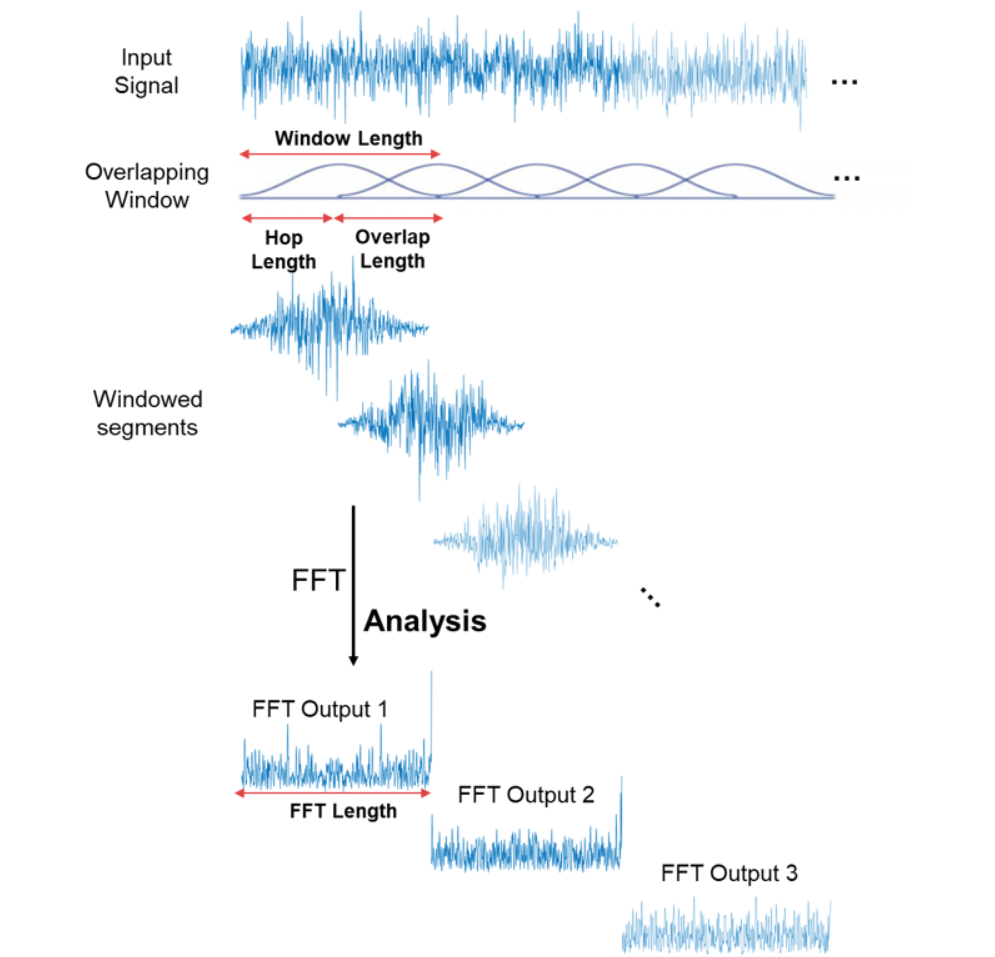

In [8]:
import numpy as np
import librosa

def audio_to_melspec(audio, sr, n_mels, n_fft=2048, hop_length=512, to_db=False):
    """
    Chuyển audio thành Mel spectrogram.

    Tham số:
    - audio: mảng âm thanh (numpy array)
    - sr: sample rate
    - n_mels: số lượng Mel bands (ví dụ: 128)
    - n_fft: kích thước FFT (thường 2048)
    - hop_length: khoảng trượt giữa các khung (thường 512)
    - to_db: nếu True, chuyển sang đơn vị dB (log-scale)

    Trả về:
    - Mel spectrogram (dạng float32 numpy array)
    """
    spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=None,
        window="hann",
        center=True,
        pad_mode="reflect",
        power=2.0,           # bình phương độ lớn -> năng lượng
        n_mels=n_mels
    )

    if to_db:
        # Chuyển từ năng lượng sang decibel (dB) – thang log, phù hợp với thị giác con người
        spec = librosa.power_to_db(spec, ref=np.max)

    return spec


In [9]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def normalize_melspec(melspec, norm_range=(0, 1)):
    """
    Chuẩn hóa giá trị Mel spectrogram về khoảng norm_range (mặc định [0, 1])

    Tham số:
    - melspec: numpy array có shape (n_mels, n_frames)
    - norm_range: tuple (min, max) của giá trị chuẩn hóa

    Trả về:
    - Mel spectrogram đã chuẩn hóa, shape gốc (n_mels, n_frames)
    """
    scaler = MinMaxScaler(feature_range=norm_range)

    # Chuyển vị để chuẩn hóa theo từng Mel-bin (feature)
    melspec_T = melspec.T

    # Fit & transform dữ liệu
    melspec_normalized = scaler.fit_transform(melspec_T)

    # Trả lại shape ban đầu
    return melspec_normalized.T


In [10]:
from sklearn.preprocessing import MinMaxScaler

def denormalize_melspec(melspec_normalized, original_melspec, norm_range=(0, 1)):
    """
    Khôi phục lại Mel spectrogram ban đầu từ phiên bản đã chuẩn hóa.

    Tham số:
    - melspec_normalized: mảng đã được normalize
    - original_melspec: mảng gốc trước khi normalize (dùng để fit scaler)
    - norm_range: khoảng chuẩn hóa ban đầu (ví dụ: (0, 1))

    Trả về:
    - Mel spectrogram đã được khôi phục lại giá trị gốc
    """
    # Tạo scaler với khoảng chuẩn hóa
    scaler = MinMaxScaler(feature_range=norm_range)

    # Chuyển vị dữ liệu gốc để fit scaler (theo trục feature)
    melspec = original_melspec.T
    scaler.fit(melspec)

    # Khôi phục giá trị từ bản chuẩn hóa
    melspec_denormalized = scaler.inverse_transform(melspec_normalized.T)

    # Trả về dữ liệu với shape ban đầu
    return melspec_denormalized.T


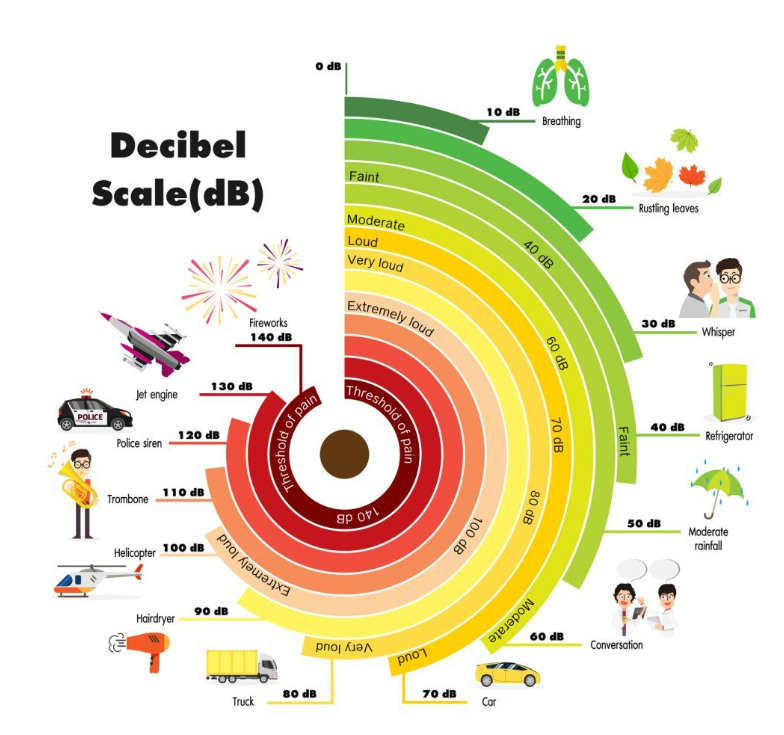

In [11]:
def melspec_to_audio(melspec, sr, n_fft=2048, hop_length=512, n_iter=64):
    """
    Biến đổi Mel spectrogram thành tín hiệu âm thanh.

    Tham số:
    - melspec: mảng Mel spectrogram (có thể ở dạng dB hoặc power)
    - sr: sample rate
    - n_fft: kích thước cửa sổ FFT
    - hop_length: độ dài bước nhảy
    - n_iter: số vòng lặp cho Griffin-Lim algorithm (tái tạo pha)

    Trả về:
    - audio_reconstructed: tín hiệu âm thanh đã tái tạo
    """
    # Nếu spectrogram ở dạng log (dB), chuyển về power
    if np.any(melspec < 0):
        melspec = librosa.db_to_power(melspec)

    # Tái tạo lại waveform từ Mel spectrogram
    audio_reconstructed = librosa.feature.inverse.mel_to_audio(
        melspec,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=None,
        window="hann",
        center=True,
        pad_mode="reflect",
        power=2.0,
        n_iter=n_iter  # dùng Griffin-Lim để khôi phục phase
    )

    return audio_reconstructed


In [12]:
import IPython.display as ipd

def display_audio_files(reconstructed_audio, sr, title="", original_audio=None):
    """
    Phát lại âm thanh trong Jupyter Notebook để so sánh:
    - Âm thanh gốc (nếu có)
    - Âm thanh tái tạo từ Mel spectrogram

    Tham số:
    - reconstructed_audio: tín hiệu âm thanh đã tái tạo (numpy array)
    - sr: sample rate (thường là 22050)
    - title: tiêu đề tuỳ chọn
    - original_audio: âm thanh gốc nếu có (numpy array)
    """
    if original_audio is not None:
        print("Original Audio:")
        ipd.display(ipd.Audio(original_audio, rate=sr))

        print("econstructed Audio (from Mel Spectrogram):")

    else:
        print(title)

    # Dù có original hay không, vẫn phát reconstructed
    ipd.display(ipd.Audio(reconstructed_audio, rate=sr))


In [13]:
def show_spectrogram(spectrogram, title="Mel-Spectrogram", denormalize=False, is_numpy=False):
    """
    Hiển thị ảnh Mel spectrogram (hoặc spectrogram thường).

    Tham số:
    - spectrogram: dữ liệu đầu vào (Tensor hoặc NumPy array)
    - title: tiêu đề biểu đồ
    - denormalize: nếu True, không giới hạn giá trị (hiển thị log dB)
    - is_numpy: nếu False → là Tensor (sẽ convert sang NumPy)
    """
    # Nếu không phải NumPy array → chuyển từ Tensor sang NumPy
    if not is_numpy:
        spectrogram = spectrogram.squeeze().cpu().numpy()

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 4))

    if denormalize:
        # Hiển thị không giới hạn giá trị (thường dùng cho log scale)
        plt.imshow(spectrogram, aspect="auto", origin="lower", cmap="viridis")
    else:
        # Normalize từ 0 → 1 (dùng khi đã scale)
        plt.imshow(spectrogram, aspect="auto", origin="lower", cmap="viridis", vmin=0, vmax=1)

    # Gắn thông tin biểu đồ
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")
    plt.colorbar()
    plt.show()


#### Xử lý dữ liệu


In [14]:
""" chúng ta duyệt qua các tệp json chứa thông tin về tệp âm thanh tương ứng, để xem
có tổng cộng bao nhiêu thể loại trên toàn bộ tập dữ liệu
"""
# 1. Đường dẫn đến thư mục chứa metadata JSON
# Tạo thư mục nếu chưa tồn tại
#if not os.path.exists("piano_audio_files"):
#    os.makedirs("piano_audio_files")

#if not os.path.exists(os.path.join("piano_audio_files", "crawled_data")):
#    os.makedirs(os.path.join("piano_audio_files", "crawled_data"))
json_dir = os.path.join("piano_audio_files", "crawled_data")

# 2. Danh sách lưu tất cả genres
all_genres = []

# 3. Duyệt qua tất cả file trong thư mục
for filename in os.listdir(json_dir):
    if filename.endswith('.json'):
        # Đường dẫn đầy đủ tới file JSON
        json_path = os.path.join(json_dir, filename)

        # Hàm load dữ liệu và trả về danh sách genres
        genres = load_and_get_genres(json_path)  # 👈 bạn cần định nghĩa hàm này

        # Thêm vào danh sách chung
        all_genres.extend(genres)

# 4. Dùng set để loại bỏ trùng lặp → chỉ lấy genres duy nhất
unique_genres = set(all_genres)
max_genres = len(unique_genres)

# 5. Hiển thị kết quả
print(f"🎵 Total unique genres: {max_genres}")
print(f"📚 Unique genres: {unique_genres}")


🎵 Total unique genres: 85
📚 Unique genres: {'Piano', 'Wonky', 'Acoustic', 'Mbaqanga', 'Glitch', 'Ambient Electronic', '20th Century Classical', 'Modern Jazz', 'New Age', 'Sound Effects', 'Hip-Hop Beats', 'Jazz', 'Rock', 'Hiplife', 'Funk', 'House', 'Pop', 'Dance', 'Alternative Hip-Hop', 'Lo-fi Electronic', 'Halloween', 'Lounge', 'Improv', 'Holiday', 'Tango', 'Classical', 'Comedy', 'Drum & Bass', 'Lo-fi Hip-Hop', 'Composed Music', 'Soundtrack', 'Minimal Electronic', 'Europe', 'Chill-out', 'Soul-RnB', 'Instrumental', 'Historic', 'Electroacoustic', 'Minimalism', 'Blues', 'Kid-Friendly', 'Novelty', 'Sound Art', 'Lo-fi Soul-RnB', 'Electronic', 'African', 'Vaporwave', 'Techno', 'Rap', 'Sound Collage', 'Radio', 'Singer-Songwriter', 'Ambient', 'Lo-fi Experimental', 'Goth', 'Talk Radio', 'Nerdcore', 'International', 'Christmas', 'Gospel', 'Big Band/Swing', 'Radio Art', 'Country & Western', 'Contemporary Classical', 'Afrobeat', 'Interview', 'Jazz: Out', 'Downtempo', 'Easy Listening', 'Unclassifia

In [15]:
genres2idx = {genre: idx for idx, genre in enumerate(unique_genres)}
idx2genres = {idx: genre for genre, idx in genres2idx.items()}

def tokenize(genres):
    return [genres2idx[genre] for genre in genres if genre in genres2idx]

def detokenize_tolist(tokens):
    return [idx2genres[token] for token in tokens if token in idx2genres]

def onehot_encode(tokens, max_genres):
    onehot = np.zeros(max_genres)
    onehot[tokens] = 1
    return onehot
def onehot_decode(onehot):
    return [idx for idx, val in enumerate(onehot) if val == 1]


In [16]:
from torch.utils.data import Dataset
import torch


class AudioDataset(Dataset):
    def __init__(self, data_dir, json_dir, sample_rate, duration, n_mels, n_genres, testset_amount=10):
        self.data_dir = data_dir # folder chứa các file .mp3
        self.json_dir = json_dir # folder chứa các file .json chứa label
        self.sample_rate = sample_rate # Sample rate chuẩn
        self.duration = duration # Thời gian mỗi đoạn âm thanh (tính bằng giây)
        self.fixed_length = sample_rate * duration # Số samples cho mỗi đoạn
        self.n_mels = n_mels
        self.n_genres = n_genres
        self.testset_amount = testset_amount

        # Tìm các file .mp3 và .json
        self.files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".mp3")]
        self.json_files = [os.path.join(json_dir, f) for f in os.listdir(json_dir) if f.endswith(".json")]

        audios = []

        for file_path, json_file_path in tqdm(zip(self.files, self.json_files),
                                              total=len(self.files),
                                              desc=f"Loading audio files{data_dir}", unit="file"):
            audio, sr = load_and_resample_audio(file_path, target_sr=sample_rate)
            genres_list = load_and_get_genres(json_file_path)

            genres_tokens = tokenize(genres_list)
            genres_encoded = onehot_encode(genres_tokens, n_genres)
            genres_input = torch.tensor(genres_encoded, dtype=torch.long).unsqueeze(0)

            n_samples = len(audio)
            n_segments = n_samples // self.fixed_length

            for i in range(n_segments):
                start = i * self.fixed_length
                end = (i + 1) * self.fixed_length
                segment = audio[start:end]

                mel_spec = audio_to_melspec(segment, sr, self.n_mels, to_db=True)
                mel_spec_norm = normalize_melspec(mel_spec)

                mel_spec_tensor = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0)
                mel_spec_norm_tensor = torch.tensor(mel_spec_norm, dtype=torch.float32).unsqueeze(0)

                audios.append((mel_spec_norm_tensor, genres_input, mel_spec_tensor))

        # Chia dữ liệu train/test
        self.audios = audios[:-testset_amount]
        self.testset = audios[-testset_amount:]

        print(f"✅ Loaded {len(self.audios)} training segments from {len(self.files)} audio files")
        print(f"🧪 Test set: {len(self.testset)} audio segments (duration: {self.duration} seconds each)")

    def __len__(self):
        return len(self.audios)

    def __getitem__(self, idx):
        mel_spec_part, genres_input, mel_spec = self.audios[idx]
        return mel_spec_part, genres_input, mel_spec


In [17]:
# xóa dữ liệu để tránh bị overload trên colab

In [18]:
import shutil

def delete_audio_files(start_index, end_index, data_dir="piano_audio_files/crawled_data/audio"):
  """
  Xóa các tệp âm thanh từ audio_start_index đến audio_end_index.

  Args:
      start_index: Chỉ số bắt đầu.
      end_index: Chỉ số kết thúc.
      data_dir: Thư mục chứa các tệp âm thanh.
  """
  for i in range(start_index, end_index + 1):
    filename = f"audio_{i:04}.mp3"
    filepath = os.path.join(data_dir, filename)
    if os.path.exists(filepath):
      try:
        os.remove(filepath)
        print(f"Đã xóa tệp: {filepath}")
      except OSError as e:
        print(f"Lỗi khi xóa tệp {filepath}: {e}")
    else:
      print(f"Tệp {filepath} không tồn tại.")





def delete_json_files(start_index, end_index, data_dir="piano_audio_files/crawled_data"):
  """
  Args:
      start_index: Chỉ số bắt đầu.
      end_index: Chỉ số kết thúc.
      data_dir: Thư mục chứa các tệp json.
  """
  for i in range(start_index, end_index + 1):
    filename = f"audio_{i:04}.json"
    filepath = os.path.join(data_dir, filename)
    if os.path.exists(filepath):
      try:
        os.remove(filepath)
        print(f"Đã xóa tệp: {filepath}")
      except OSError as e:
        print(f"Lỗi khi xóa tệp {filepath}: {e}")
    else:
      print(f"Tệp {filepath} không tồn tại.")


In [19]:
# Xóa dữ liệu audio từ audio_0070 - 0092
delete_audio_files(601, 793)
delete_json_files(601, 793)

Đã xóa tệp: piano_audio_files/crawled_data/audio/audio_0601.mp3
Đã xóa tệp: piano_audio_files/crawled_data/audio/audio_0602.mp3
Đã xóa tệp: piano_audio_files/crawled_data/audio/audio_0603.mp3
Đã xóa tệp: piano_audio_files/crawled_data/audio/audio_0604.mp3
Đã xóa tệp: piano_audio_files/crawled_data/audio/audio_0605.mp3
Đã xóa tệp: piano_audio_files/crawled_data/audio/audio_0606.mp3
Đã xóa tệp: piano_audio_files/crawled_data/audio/audio_0607.mp3
Đã xóa tệp: piano_audio_files/crawled_data/audio/audio_0608.mp3
Đã xóa tệp: piano_audio_files/crawled_data/audio/audio_0609.mp3
Đã xóa tệp: piano_audio_files/crawled_data/audio/audio_0610.mp3
Đã xóa tệp: piano_audio_files/crawled_data/audio/audio_0611.mp3
Đã xóa tệp: piano_audio_files/crawled_data/audio/audio_0612.mp3
Đã xóa tệp: piano_audio_files/crawled_data/audio/audio_0613.mp3
Đã xóa tệp: piano_audio_files/crawled_data/audio/audio_0614.mp3
Đã xóa tệp: piano_audio_files/crawled_data/audio/audio_0615.mp3
Đã xóa tệp: piano_audio_files/crawled_da

In [20]:
import os
from torch.utils.data import DataLoader

# Cấu hình âm thanh và tập dữ liệu
sample_rate = 22050        # 22.05kHz là chuẩn phổ biến cho âm nhạc
duration = 3               # Mỗi đoạn âm thanh dài 3 giây
n_mels = 256               # Số lượng Mel bands trong Mel-spectrogram
batch_size = 128           # Số lượng mẫu/mini-batch

# Đường dẫn dữ liệu
audio_dir = os.path.join("piano_audio_files", "crawled_data", "audio")
json_dir = os.path.join("piano_audio_files", "crawled_data")

# Số lượng mẫu dành cho test
testset_amount = 32

# Khởi tạo tập huấn luyện
trainset = AudioDataset(audio_dir, json_dir, sample_rate, duration,
                        n_mels, max_genres, testset_amount=testset_amount)

# Lấy tập test từ trainset đã tách sẵn
testset = trainset.testset

# Kiểm tra nếu không có dữ liệu .mp3
if len(trainset) == 0:
    raise ValueError(f"No .wav file found in {audio_dir}.")

# Dataloader dùng để lấy dữ liệu thành batch trong quá trình train
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=testset_amount, shuffle=False, num_workers=2)


Loading audio filespiano_audio_files/crawled_data/audio: 100%|██████████| 600/600 [15:16<00:00,  1.53s/file]

✅ Loaded 37199 training segments from 600 audio files
🧪 Test set: 32 audio segments (duration: 3 seconds each)


tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
130


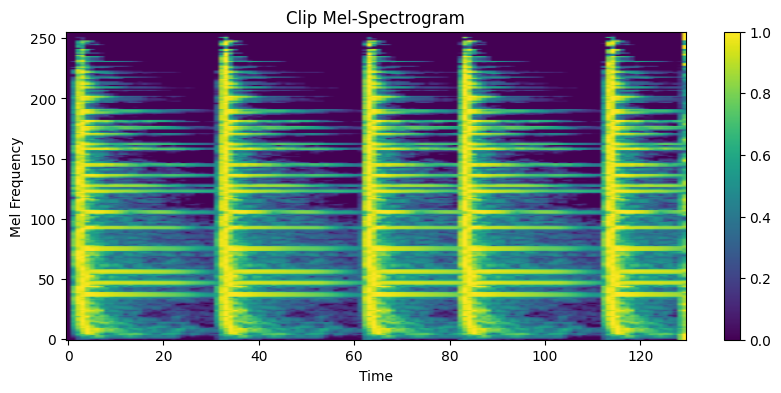

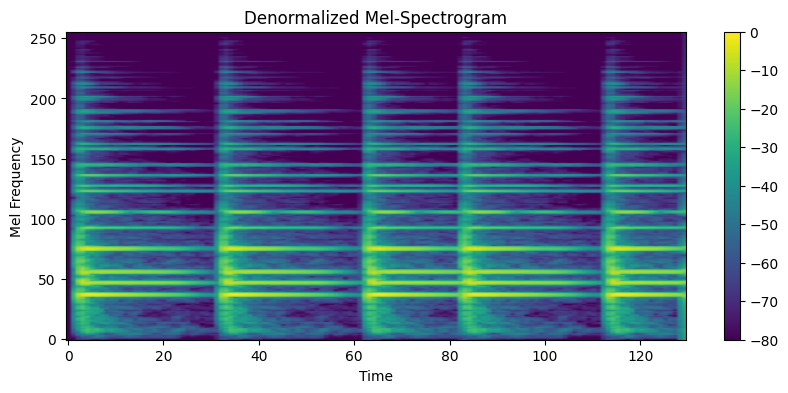

Original Audio after convert to Spectrogram and back to Audio


In [21]:
audios = trainloader.dataset.audios.copy()

frame = audios[0][0].shape[-1]
print(audios[0][1])
print(frame)

for i in range(1):
    show_spectrogram(audios[i][0], title="Clip Mel-Spectrogram")
    spec_denorm = denormalize_melspec(audios[i][0].numpy().squeeze(), audios[i][2].numpy().squeeze())
    show_spectrogram(torch.tensor(spec_denorm), title="Denormalized Mel-Spectrogram", denormalize=True)
    audio_reconstructed = melspec_to_audio(spec_denorm, sample_rate)
    display_audio_files(audio_reconstructed, sample_rate, title="Original Audio after convert to Spectrogram and back to Audio")

#### Xây dựng mô hình

In [22]:
import torch
import torch.nn as nn
import numpy as np

class CVAE(nn.Module):
    def __init__(self, d_model, latent_dim, n_frames, n_mels, n_genres):
        super(CVAE, self).__init__()
        self.d_model = d_model
        self.latent_dim = latent_dim
        self.n_frames = int(np.ceil(n_frames / 8))
        self.n_mels = int(np.ceil(n_mels / 8))
        self.n_genres = n_genres

        # Encoder
        self.encoder = nn.Sequential(
            # 1: đại diện cho 1 kênh dữ liệu âm thanh gốc, tức Mel-Spectrogram có shape [B, 1, H, W]
            # n_genres: là số thể loại nhạc đã được one-hot encode, mỗi thể loại là một chiều riêng biệt
            nn.Conv2d(1 + n_genres, d_model, kernel_size=3, stride=2, padding=1), # [B, d, ceil(n_mels/2), ceil(n_frame/2)]
            nn.BatchNorm2d(d_model),
            nn.SiLU(),
            nn.Dropout2d(0.05),

            nn.Conv2d(d_model, d_model * 2, kernel_size=3, stride=2, padding=1),  # [B, 2*d, ceil(n_mels/2**2), ceil(n_frames/2**2)]
            nn.BatchNorm2d(d_model * 2),
            nn.SiLU(),
            nn.Dropout2d(0.1),

            nn.Conv2d(d_model * 2, d_model * 4, kernel_size=3, stride=2, padding=1), # [B, 4*d, ceil(n_mels/2**3), ceil(n_frames/2**3)]
            nn.BatchNorm2d(d_model * 4),
            nn.SiLU(),
            nn.Dropout2d(0.15),

            nn.AdaptiveAvgPool2d((1, 1)), # [B, 4*d, 1, 1]
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(d_model * 4, latent_dim)
        self.fc_logvar = nn.Linear(d_model * 4, latent_dim)

        self.decoder_input = nn.Linear(latent_dim + n_genres, d_model * 4 * self.n_frames * self.n_mels)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(d_model * 4, d_model * 2, kernel_size=3, stride=2, padding=1, output_padding=(1, 0)),
            nn.BatchNorm2d(d_model * 2),
            nn.SiLU(),
            nn.Dropout2d(0.1),

            nn.ConvTranspose2d(d_model * 2, d_model, kernel_size=3, stride=2, padding=1, output_padding=(1, 0)),
            nn.BatchNorm2d(d_model),
            nn.SiLU(),
            nn.Dropout2d(0.05),

            nn.ConvTranspose2d(d_model, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, genres_input):
        ori_genres_embed = genres_input.view(genres_input.size(0), -1)
        genres_embed = ori_genres_embed.unsqueeze(-1).unsqueeze(-1)
        genres_embed = genres_embed.expand(-1, -1, x.size(2), x.size(3))
        x_genres = torch.cat((x, genres_embed), dim=1)

        h = x_genres
        shortcuts = []
        for block in self.encoder:
            h = block(h)
            if isinstance(block, nn.SiLU):
                shortcuts.append(h)

        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        z = self.reparameterize(mu, logvar)
        z_genres = torch.cat((z, ori_genres_embed), dim=1)

        h_dec = self.decoder_input(z_genres)
        h_dec = h_dec.view(-1, self.d_model * 4, self.n_frames, self.n_mels)

        for block in self.decoder:
            if isinstance(block, nn.ConvTranspose2d) and shortcuts:
                shortcut = shortcuts.pop()
                h_dec = h_dec + shortcut
            h_dec = block(h_dec)

        recon = h_dec[:, :, :x.size(2), :x.size(3)]
        return recon, mu, logvar


## 6. Training

In [23]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + KLD

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [25]:
def train_vae(model, dataloader, optimizer, scheduler, num_epochs, verbose_interval=50):
    model.train()
    losses = []
    for epoch in tqdm(range(num_epochs), desc="Training", unit="epoch"):
        train_loss = 0
        for batch_idx, (data, genres_input, ori_data) in enumerate(dataloader):
            data = data.to(device)
            genres_input = genres_input.to(device)

            optimizer.zero_grad()

            recon, mu, logvar = model(data, genres_input)
            loss = loss_function(recon, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        scheduler.step()
        avg_loss = train_loss / len(dataloader.dataset)
        losses.append(avg_loss)
        print(f"Epoch {epoch}/{num_epochs}, Loss: {avg_loss:.4f}, Lr: {scheduler.get_last_lr()[0]}")
        if epoch == 0 or (epoch + 1) % verbose_interval == 0:
            data = data[0].detach().cpu()
            recon_img = recon[0].detach().cpu()
            show_spectrogram(data, title="Original Spectrogram")
            show_spectrogram(recon_img, title="Reconstructed Spectrogram")
    return mu, logvar, losses

Total number of parameters: 30657601


Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch 0/100, Loss: 842.1720, Lr: 0.0002


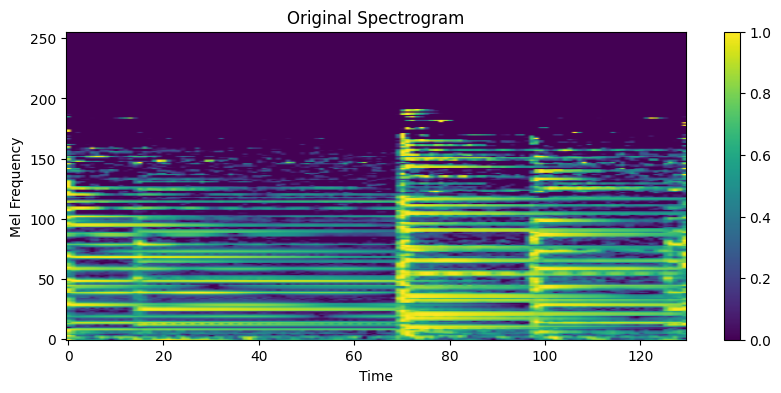

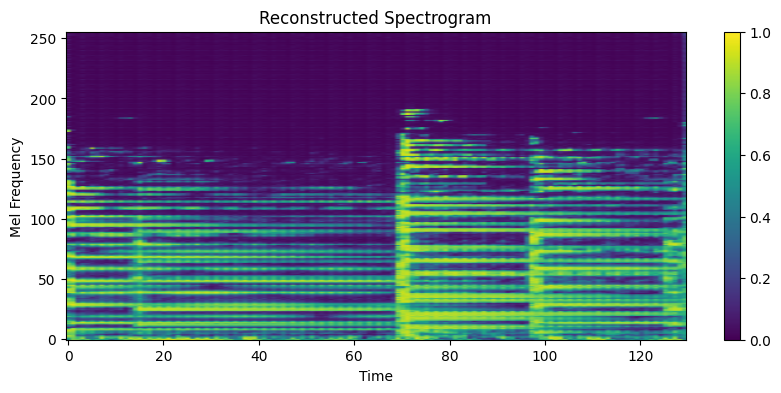

Training:   2%|▏         | 2/100 [05:26<4:43:57, 173.85s/epoch]

Epoch 1/100, Loss: 387.5812, Lr: 0.0002


Training:   3%|▎         | 3/100 [07:17<3:54:46, 145.23s/epoch]

Epoch 2/100, Loss: 320.4157, Lr: 0.0002


Training:   4%|▍         | 4/100 [09:08<3:30:39, 131.67s/epoch]

Epoch 3/100, Loss: 269.8122, Lr: 0.0002


Training:   5%|▌         | 5/100 [10:59<3:16:41, 124.23s/epoch]

Epoch 4/100, Loss: 256.6930, Lr: 0.0002


Training:   6%|▌         | 6/100 [12:50<3:07:34, 119.73s/epoch]

Epoch 5/100, Loss: 117.9659, Lr: 0.0002


Training:   7%|▋         | 7/100 [14:41<3:01:13, 116.92s/epoch]

Epoch 6/100, Loss: 40.7155, Lr: 0.0002


Training:   8%|▊         | 8/100 [16:32<2:56:16, 114.97s/epoch]

Epoch 7/100, Loss: 35.2347, Lr: 0.0002


Training:   9%|▉         | 9/100 [18:22<2:52:20, 113.64s/epoch]

Epoch 8/100, Loss: 31.6137, Lr: 0.0002
Epoch 9/100, Loss: 29.5022, Lr: 0.0002


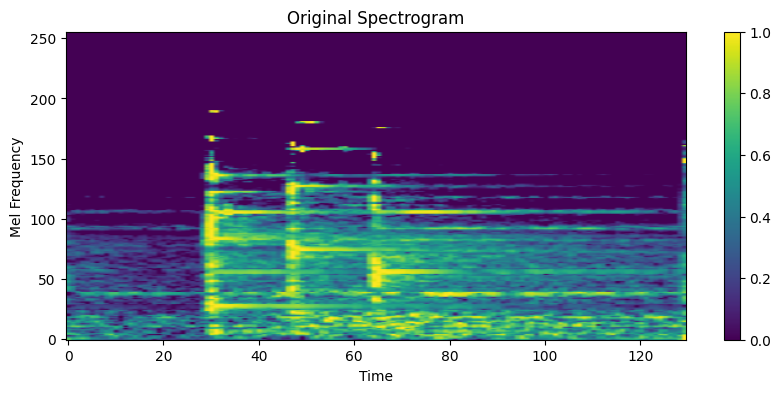

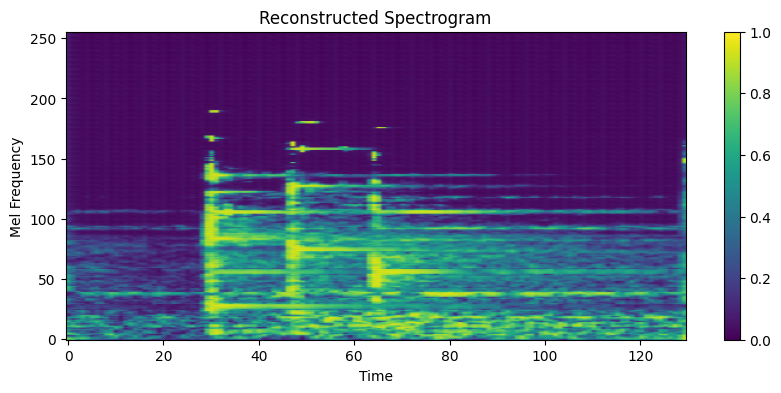

Training:  11%|█         | 11/100 [22:04<2:46:31, 112.26s/epoch]

Epoch 10/100, Loss: 28.3228, Lr: 0.0002


Training:  12%|█▏        | 12/100 [23:55<2:43:53, 111.74s/epoch]

Epoch 11/100, Loss: 25.3513, Lr: 0.0002


Training:  13%|█▎        | 13/100 [25:46<2:41:33, 111.42s/epoch]

Epoch 12/100, Loss: 23.9282, Lr: 0.0002


Training:  14%|█▍        | 14/100 [27:36<2:39:18, 111.15s/epoch]

Epoch 13/100, Loss: 22.8245, Lr: 0.0002


Training:  15%|█▌        | 15/100 [29:27<2:37:12, 110.97s/epoch]

Epoch 14/100, Loss: 21.5950, Lr: 0.0002


Training:  16%|█▌        | 16/100 [31:18<2:35:19, 110.95s/epoch]

Epoch 15/100, Loss: 20.2265, Lr: 0.0002


Training:  17%|█▋        | 17/100 [33:08<2:33:19, 110.84s/epoch]

Epoch 16/100, Loss: 19.3408, Lr: 0.0002


Training:  18%|█▊        | 18/100 [34:59<2:31:27, 110.83s/epoch]

Epoch 17/100, Loss: 18.2583, Lr: 0.0002


Training:  19%|█▉        | 19/100 [36:50<2:29:30, 110.75s/epoch]

Epoch 18/100, Loss: 17.6924, Lr: 0.0002
Epoch 19/100, Loss: 16.5937, Lr: 0.0002


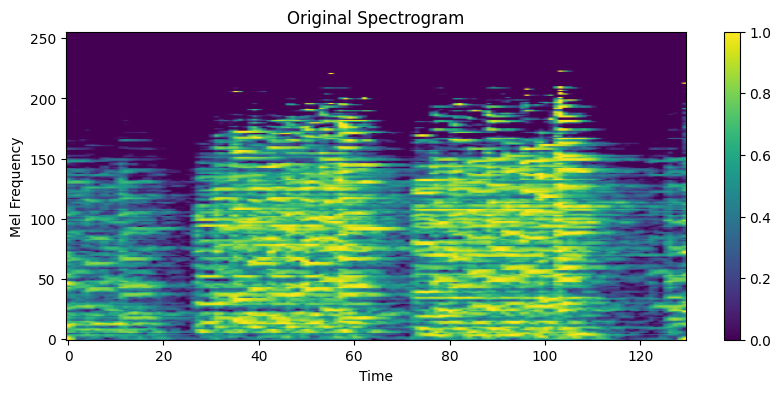

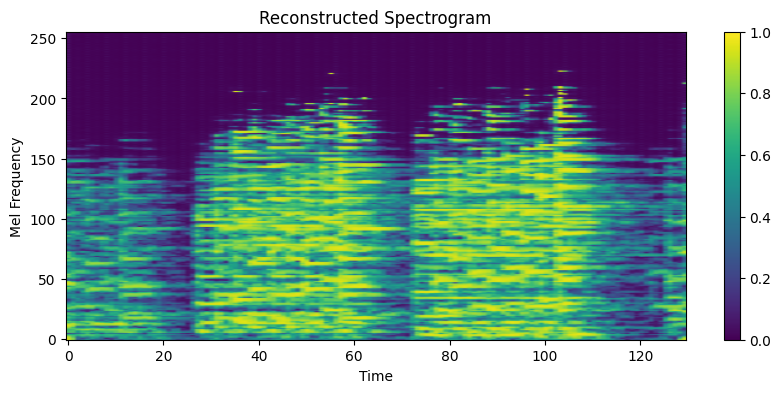

Training:  21%|██        | 21/100 [40:32<2:26:03, 110.93s/epoch]

Epoch 20/100, Loss: 15.7717, Lr: 0.0002


Training:  22%|██▏       | 22/100 [42:22<2:23:57, 110.74s/epoch]

Epoch 21/100, Loss: 14.8189, Lr: 0.0002


Training:  23%|██▎       | 23/100 [44:13<2:22:06, 110.74s/epoch]

Epoch 22/100, Loss: 14.4991, Lr: 0.0002


Training:  24%|██▍       | 24/100 [46:04<2:20:25, 110.86s/epoch]

Epoch 23/100, Loss: 13.5830, Lr: 0.0002


Training:  25%|██▌       | 25/100 [47:54<2:18:23, 110.72s/epoch]

Epoch 24/100, Loss: 13.2403, Lr: 0.0002


Training:  26%|██▌       | 26/100 [49:45<2:16:34, 110.73s/epoch]

Epoch 25/100, Loss: 12.5136, Lr: 0.0002


Training:  27%|██▋       | 27/100 [51:36<2:14:47, 110.79s/epoch]

Epoch 26/100, Loss: 12.2654, Lr: 0.0002


Training:  28%|██▊       | 28/100 [53:27<2:13:05, 110.91s/epoch]

Epoch 27/100, Loss: 11.7208, Lr: 0.0002


Training:  29%|██▉       | 29/100 [55:18<2:11:11, 110.87s/epoch]

Epoch 28/100, Loss: 11.2561, Lr: 0.0002
Epoch 29/100, Loss: 10.9389, Lr: 0.0002


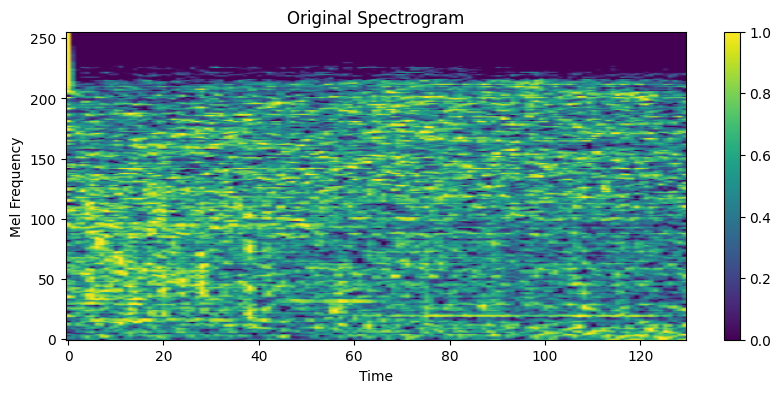

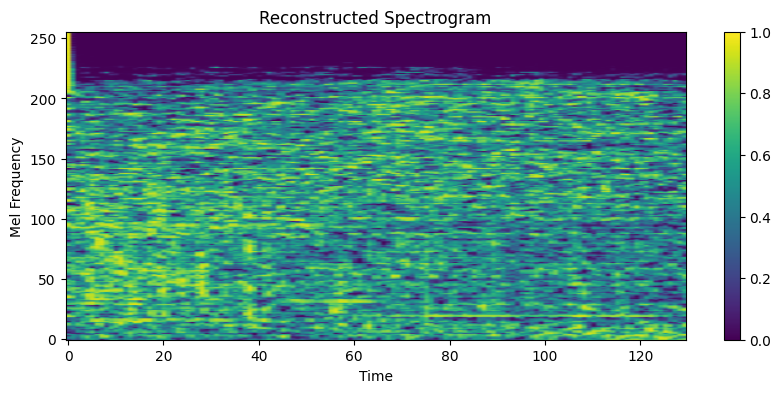

Training:  31%|███       | 31/100 [59:00<2:07:35, 110.95s/epoch]

Epoch 30/100, Loss: 10.1664, Lr: 0.0002


In [ ]:


d_model = 64
latent_dim = 128
lr = 2e-4
num_epochs = 100
step_size = num_epochs//2
verbose_interval = num_epochs//10
gamma = 0.5

model = CVAE(d_model, latent_dim, n_mels, frame, max_genres).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
# Điều chỉnh Learning Rate (LR) theo từng bước (epoch) để tối ưu quá trình huấn luyện mô hình.
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")
mu, logvar, losses = train_vae(model, trainloader, optimizer, scheduler, num_epochs, verbose_interval=verbose_interval)

In [ ]:
torch.save(model.state_dict(), "model_checkpoint123.pth")

model = CVAE(d_model, latent_dim, n_mels, frame, max_genres).to(device)
model.load_state_dict(torch.load("model_checkpoint123.pth"))
model.eval()

In [ ]:
def plot_losses(losses, title="Training Loss", xlabel="Epochs", ylabel="Loss", color='b', grid=True):
    plt.figure(figsize=(10, 6))
    plt.plot(losses, color=color, linewidth=2)
    plt.title(title, fontsize=16, fontweight="bold")
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(grid, linestyle="--", alpha=0.6)

    min_loss_idx = losses.index(min(losses))
    max_loss_idx = losses.index(max(losses))

    plt.annotate(f"Min Loss: {min(losses):.4f}",
                 xy=(min_loss_idx, min(losses)),
                 xytext=(min_loss_idx + 1, min(losses) + 0.1),
                 arrowprops=dict(arrowstyle="->", color="green"),
                 fontsize=12, color='green')

    plt.annotate(f"Max Loss: {max(losses):.4f}",
                 xy=(max_loss_idx, max(losses)),
                 xytext=(max_loss_idx + 1, max(losses) + 0.1),
                 arrowprops=dict(arrowstyle="->", color="red"),
                 fontsize=12, color="red")

    plt.tight_layout()
    plt.show()

plot_losses(losses)


## 7. Inference

In [ ]:
def inference(model, testloader):
    model.eval()
    with torch.no_grad():
        data, genres_input, ori_data = next(iter(testloader))
        data = data.to(device)
        genres_input = genres_input.to(device)
        recon, _, _ = model(data, genres_input)
        return recon, genres_input, ori_data

In [ ]:
gen_mels, genres_input, ori_data = inference(model, testloader)
recon_audios = []
ori_audios = []
num_samples = 5

for i in range(len(gen_mels[:num_samples])):
    show_spectrogram(ori_data[i], title=f"Original Spectrogram {i+1}", denormalize=True)
    ori_reconstructed = melspec_to_audio(ori_data[i].cpu().numpy().squeeze(), sample_rate)
    ori_audios.append(ori_reconstructed)

    spec_denorm = denormalize_melspec(gen_mels[i].cpu().numpy().squeeze(), ori_data[i].cpu().numpy().squeeze())
    show_spectrogram(spec_denorm, title=f"Reconstructed Spectrogram {i+1}", denormalize=True, is_numpy=True)
    audio_reconstructed = melspec_to_audio(spec_denorm, sample_rate)
    recon_audios.append(audio_reconstructed)

    display_audio_files(audio_reconstructed, sample_rate, original_audio=ori_reconstructed)
    print("-"*100, end="\n\n")

ori_audios = np.concatenate(ori_audios)
display_audio_files(ori_audios, sample_rate, title="Connect all original audio")
recon_audios = np.concatenate(recon_audios)
display_audio_files(recon_audios, sample_rate, title="Connect all reconstructed audio")

## 8. Inference (generative)

In [ ]:
def generate(model, dataloader, genres_list, num_samples=5, diff_level=1):
    model.eval()
    with torch.no_grad():
        data, old_genres_input, ori_data = next(iter(dataloader))
        data = data.to(device)

        genres_tokens = tokenize(genres_list)
        genres_input = onehot_encode(genres_tokens, model.n_genres)
        genres_input = torch.tensor(genres_input, dtype=torch.long).unsqueeze(0)
        genres_input = genres_input.repeat(old_genres_input.shape[0], 1)
        genres_input = genres_input.to(device)

        recon, mu, logvar = model(data, genres_input)
        ori_audios = []
        recon_audios = []
        for i in range(num_samples):
            old_genres_list = detokenize_tolist(onehot_decode(old_genres_input[i].squeeze().tolist()))
            show_spectrogram(data[i], title="Original Spectrogram with Genres: " + ", ".join(old_genres_list))
            show_spectrogram(recon[i], title="Reconstructed Spectrogram with Genres: " + ", ".join(genres_list))

            diff_spectrogram = torch.abs(data[i] - recon[i]) * diff_level
            show_spectrogram(diff_spectrogram, title=f"Difference Spectrogram (|Original - Reconstructed|) * {diff_level}")
            print("Loss: ", loss_function(recon[i], data[i], mu, logvar).item())

            spec_denorm = denormalize_melspec(recon[i].cpu().numpy().squeeze(), ori_data[i].cpu().numpy().squeeze())
            audio_reconstructed = melspec_to_audio(spec_denorm, sr=sample_rate)
            ori_audio = melspec_to_audio(ori_data[i].cpu().numpy().squeeze(), sr=sample_rate)

            recon_audios.append(audio_reconstructed)
            ori_audios.append(ori_audio)

            display_audio_files(ori_audio, sample_rate, title="Reconstructed Audio with Genres: " + ", ".join(old_genres_list))
            display_audio_files(audio_reconstructed, sample_rate, title="Reconstructed Audio with Genres: " + ", ".join(genres_list))

        if num_samples > 1:
            print("-"*100, "Connect all audio", "-"*100)
            recon_ori_audios = np.concatenate(ori_audios)
            display_audio_files(recon_ori_audios, sample_rate, title="Connect all original audio")
            recon_audios = np.concatenate(recon_audios)
            display_audio_files(recon_audios, sample_rate, title="Connect all reconstructed audio")